# Pytrends & BTC data + Predictions tests

In this notebook :
- Pytrends, get data from expressions on Google Trends
- Webscraping BTC price on CoinMarketCap
- Plots legends, ax, titles
- Join function
- Get_evo function to calculate variation percentage
- Get_next_week to create a list with next week price
- Predictions with regression algorithms
- Some tries on predict BTC price (week +1)

In [1]:
# https://www.mdpi.com/1911-8074/12/2/103/pdf
# https://www.researchgate.net/publication/306272793_Predicting_Fluctuations_in_Cryptocurrency_Transactions_Based_on_User_Comments_and_Replies
# Also, there is a paper of Aleh Tsyvinski & Yukun Liu from Yale University (momentum effect, google searches)

# Tool https://www.octoparse.com/pricing
# Chrome Extension https://www.scrapehero.com/how-to-scrape-historical-search-data-from-twitter/
# API for FearScore https://alternative.me/crypto/fear-and-greed-index/#fng-history
# Sentiment Analysis https://hackernoon.com/twitter-scraping-text-mining-and-sentiment-analysis-using-python-b95e792a4d64

In [2]:
# Main librairies
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pytrends (https://github.com/GeneralMills/pytrends)
from pytrends.request import TrendReq
# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()

# Web scraping
import requests
from bs4 import BeautifulSoup
from IPython.display import display_html

# Plus
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.set_option('display.max_rows', 400)

In [3]:
expressions_list = ['btc','bitcoin','binance','coin market cap','bittrex','xrp', 'ethereum','crypto','sell bitcoin',
                    'bitcoin price','bitcoin manipulation']

In [4]:
# Set the search expression(s)
pytrend.build_payload(kw_list=['btc'])

# Create our dataframe
interest_over_time_df = pytrend.interest_over_time()

## Oupss

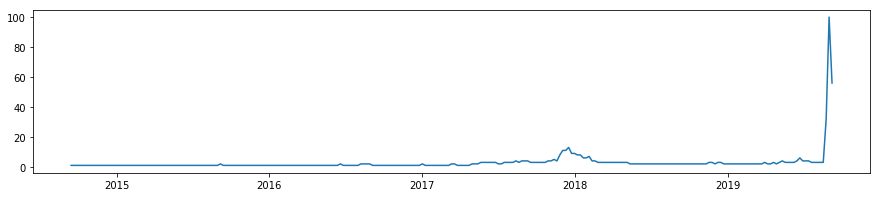

In [5]:
# Something goes wrong with the expression 'btc' and 'binance' 
# See article "Bitcoin suspicions of price manipulation after an explosion of Google searches" (Sept, 2019)
# Yes EXPLOSION. Too big to be true. The crypto buzz of december 2017 looks ridiculous now (score of 12/100).
f = plt.subplots(figsize = (15,3))
plt.plot(interest_over_time_df['btc'])

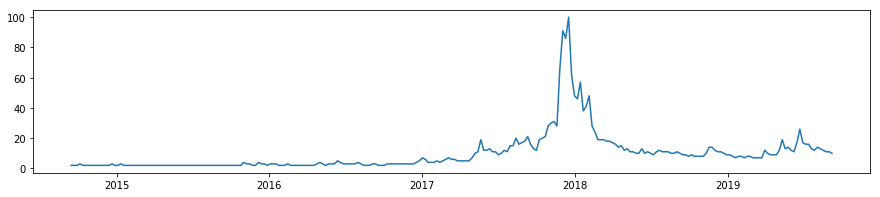

In [6]:
# Let set something more realistic, 'bitcoin' searches looks better
pytrend.build_payload(kw_list=['bitcoin'])
interest_over_time_df = pytrend.interest_over_time()

f = plt.subplots(figsize = (15,3))
plt.plot(interest_over_time_df['bitcoin'])

## Dataframe 1 : Google Trend

In [7]:
df_trend = interest_over_time_df.copy()
#df.reset_index(level=0, inplace=True)
#df = df[df['date'] > '2016-12-31']
#df = df.set_index('date')

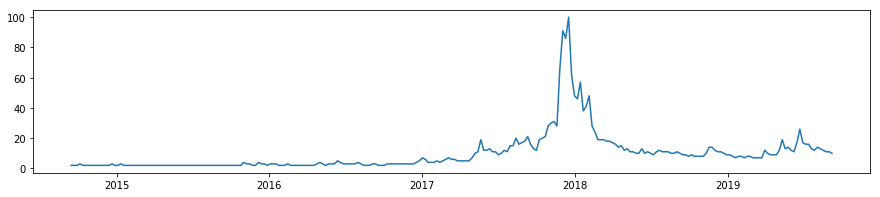

In [8]:
f, ax = plt.subplots(1, 1, figsize = (15,3))
plt.plot(df_trend['bitcoin'])

## Dataframe 2 : BTC Price

In [9]:
def get_csv_scrap_btc():
    # Date parameters
    start_date = '20140914'
    end_date = '20190930'

    # Web scrapping on https://coinmarketcap.com
    url = f'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start={start_date}&end={end_date}'
    r = requests.get(url)
    bitcoin = BeautifulSoup(r.text, 'lxml')

    # Data preparation
    bitcoin = bitcoin.find_all('table', class_='table')[0]
    html_bitcoin = str(bitcoin)
    bitcoin_stocks = pd.read_html(html_bitcoin)[0]
    
    bitcoin_stocks = pd.DataFrame(bitcoin_stocks)
    bitcoin_stocks['Date'] = pd.to_datetime(bitcoin_stocks['Date'])
    
    return bitcoin_stocks

In [10]:
df_btc = get_csv_scrap_btc()
df_btc = df_btc.set_index('Date')
print(df_btc.head())

               Open*      High       Low   Close**       Volume    Market Cap
Date                                                                         
2019-09-10  10336.41  10394.35  10020.57  10115.98  14906809639  181360731383
2019-09-09  10443.23  10450.31  10144.93  10334.97  17595943368  185263578990
2019-09-08  10518.11  10595.64  10409.09  10441.28  13670567493  187150078007
2019-09-07  10353.93  10558.67  10348.92  10517.25  15307366476  188488525926
2019-09-06  10578.20  10898.76  10292.30  10353.30  19536574783  185530405363


## Plot & Join dataframes

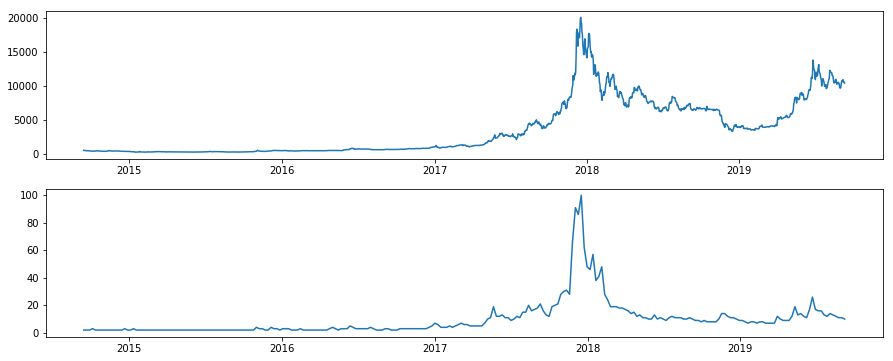

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,6))
ax1.plot(df_btc['High'])
ax2.plot(df_trend['bitcoin'])

In [12]:
# Sort the df_btc rows like df_trend
df_btc = df_btc.reindex(index=df_btc.index[::-1])

#pd.merge(df_trend.reset_index(), df_btc.reset_index(), how="left", left_on='date', right_on='Date')
#pd.merge(df_trend, df_btc, left_index=True, right_index=True)
data = df_trend.join(df_btc)

## Prepare data and EDA

In [13]:
data['Price'] = (data['Open*'] + data['High'] + data['Low'] + data['Close**']) / 4
data['Price_log'] = np.log(data['Price'])
data['bitcoin_log'] = np.log(data['bitcoin'])

data = data.drop(['isPartial','Open*','High','Low','Close**'], axis = 1)

In [14]:
def get_evo(df, col):
    evo_list = []
    for i in range(len(df[col])):
        if i != 0:
            evo_list.append(np.round(((df[col][i] - df[col][i-1]) / df[col][i-1]) * 100, 2))
        else:
            evo_list.append(0)
    return evo_list

In [15]:
data['Price_evo'] = get_evo(data, 'Price')
data['Trend_evo'] = get_evo(data, 'bitcoin')

data['Price_evo_abs'] = np.abs(data['Price_evo'])
data['Trend_evo_abs'] = np.abs(data['Trend_evo'])

In [16]:
# Trying to scale the evolution percentage multiplying the result  by |Vi+1 - Vi| / Vmax
def get_evo_plus(df, col):
    evo_list = []
    for i in range(len(df[col])):
        if i != 0:
            evo_list.append(
                np.round((((df[col][i] - df[col][i-1]) / df[col][i-1]) * 100) * (np.abs(df[col][i] - df[col][i-1]) / df[col].max())
                         , 2))
        else:
            evo_list.append(0)
    return evo_list

In [17]:
data['Price_evo+'] = get_evo_plus(data, 'Price')
data['Trend_evo+'] = get_evo_plus(data, 'bitcoin')

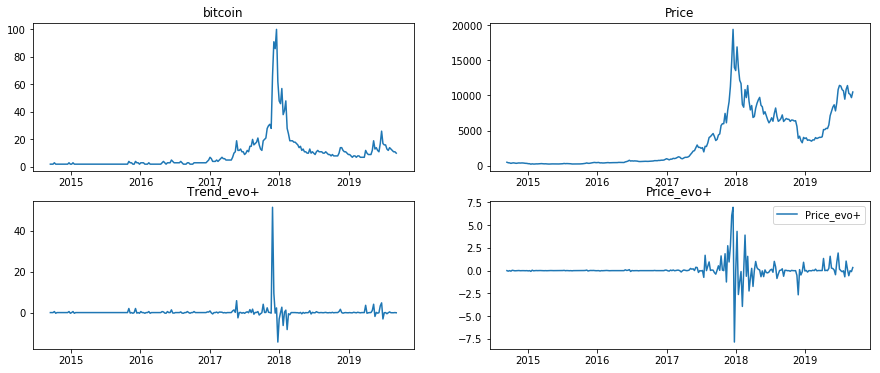

In [36]:
f, ax = plt.subplots(2, 2, figsize=(15, 6))
ax[0,0].plot(data['bitcoin'])
ax[0,0].title.set_text('bitcoin')

ax[0,1].plot(data['Price'])
ax[0,1].title.set_text('Price')

ax[1,0].plot(data['Trend_evo+'])
ax[1,0].title.set_text('Trend_evo+')

ax[1,1].plot(data['Price_evo+'])
ax[1,1].title.set_text('Price_evo+')
plt.legend()

## Create a target variable (the next week bitcoin price)

In [19]:
def get_next_week(data):
    ''' data example: df['col'] '''
    nw_prices = []
    for i in range(len(data)):
        if i < (len(data) - 1):
            nw_prices.append(data[i+1])
        else:
            nw_prices.append(data[i])
    return nw_prices

In [20]:
data['Price_nw'] = get_next_week(data['Price'])
data['Price_log_nw'] = get_next_week(data['Price_log'])

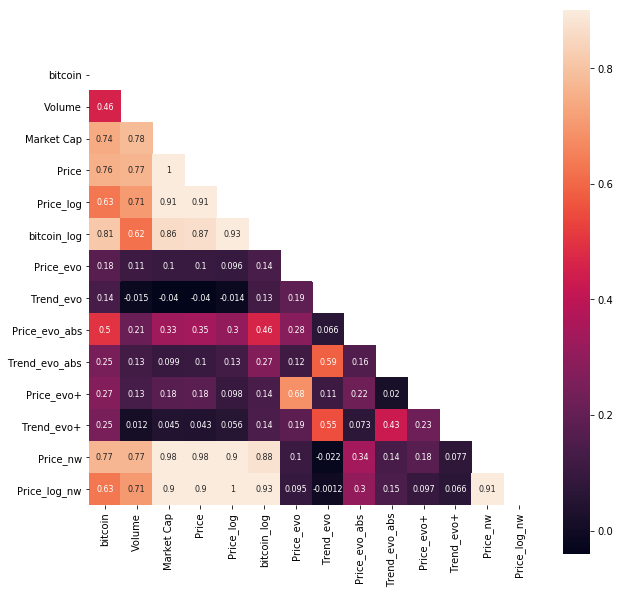

In [21]:
plt.subplots(figsize=(10,10))
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), mask=mask, vmax=.9, square=True, annot=True, annot_kws={'size': 8},)

In [22]:
data.head()

,bitcoin,Volume,Market Cap,Price,Price_log,bitcoin_log,Price_evo,Trend_evo,Price_evo_abs,Trend_evo_abs,Price_evo+,Trend_evo+,Price_nw,Price_log_nw
date,,,,,,,,,,,,,,
2014-09-14,2,13105500,6340778582,478.2450,6.170123,0.693147,0.00,0.00,0.00,0.00,0.00,0.00,403.1275,5.999253
2014-09-21,2,26580100,5303651275,403.1275,5.999253,0.693147,-15.71,0.00,15.71,0.00,-0.06,0.00,388.0000,5.961005
2014-09-28,2,23613300,5025729375,388.0000,5.961005,0.693147,-3.75,0.00,3.75,0.00,-0.00,0.00,320.1325,5.768735
2014-10-05,3,83308096,4279040870,320.1325,5.768735,1.098612,-17.49,50.00,17.49,50.00,-0.06,0.50,369.1825,5.911291
2014-10-12,2,17552800,5063689090,369.1825,5.911291,0.693147,15.32,-33.33,15.32,33.33,0.04,-0.33,390.3000,5.966916


## Predictions on Bitcoin price (week + 1)

In [23]:
# import machine learning librairies
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from datetime import datetime

from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
# from sklearn.svm import SVR
# from lightgbm import LGBMRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor
# from mlxtend.regressor import StackingCVRegressor
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor

### First try, train_test_split random

In [24]:
df = data.drop('Price_nw', axis=1)
# create our training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df, df['Price_log_nw'], test_size = 0.3, random_state = 0)
X_train = X_train.drop('Price_log_nw', axis=1)
X_valid = X_valid.drop('Price_log_nw', axis=1)
print('X_train:', X_train.shape)
print('X_test:', X_valid.shape)
print('y_train:', y_train.shape)
print('y_test:', y_valid.shape)

X_train: (182, 12)
X_test: (79, 12)
y_train: (182,)
y_test: (79,)


In [25]:
# define our score measure
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
scorer = "neg_mean_squared_error"
def cv_rmse(model, x, y):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring=scorer, cv=kfolds))
    return(rmse)

In [26]:
# define algorithms parameters (need to try others parameters 1, 0.1, ..)
alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_enet = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
l1ratio_enet = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [27]:
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
y_pred1 = lr_fit.predict(X_valid)

ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds))
ridge_fit = ridge.fit(X_train, y_train)
y_pred2 = ridge_fit.predict(X_valid)

lasso = make_pipeline(StandardScaler(), LassoCV(max_iter=1e7, alphas=alphas_lasso, random_state=42, cv=kfolds))
lasso_fit = lasso.fit(X_train, y_train)
y_pred3 = lasso_fit.predict(X_valid)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to floa

In [28]:
dat = pd.DataFrame({'Real':np.exp(y_valid), 'Pred_LR':np.exp(y_pred1), 'Pred_Ridge':np.exp(y_pred2),'Pred_Lasso':np.exp(y_pred3)})
dat = dat.sort_index()

dat['Pred_mean'] = (dat['Pred_LR'] + dat['Pred_Ridge'] + dat['Pred_Lasso']) / 3

In [29]:
def get_timepred(data):
    pred = []
    for i in range(len(data)):
        if i != 0:
            pred.append(data[i-1])
        else:
            pred.append(data[i])
    return pred

In [30]:
dat['Pred_LR'] = get_timepred(dat['Pred_LR'])
dat['Pred_Ridge'] = get_timepred(dat['Pred_Ridge'])
dat['Pred_Lasso'] = get_timepred(dat['Pred_Lasso'])
dat['Pred_mean'] = get_timepred(dat['Pred_mean'])

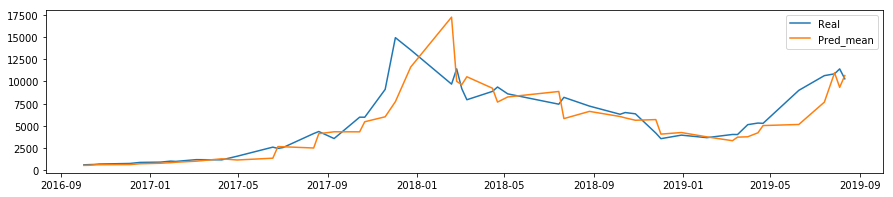

In [31]:
f, ax = plt.subplots(1, 1, figsize = (15,3))
plt.plot(dat['Real'][-50:])
#plt.plot(dat['Pred_LR'])
#plt.plot(dat['Pred_Ridge'])
#plt.plot(dat['Pred_Lasso'])
plt.plot(dat['Pred_mean'][-50:])
plt.legend()

### Second try, choosing continuous split

In [32]:
X_train = df[0:182].drop('Price_log_nw', axis=1)
y_train = df[0:182]['Price_log_nw']
X_valid = df[182:].drop('Price_log_nw', axis=1)
y_valid = df[182:]['Price_log_nw']

lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
y_pred1 = lr_fit.predict(X_valid)

ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds))
ridge_fit = ridge.fit(X_train, y_train)
y_pred2 = ridge_fit.predict(X_valid)

lasso = make_pipeline(StandardScaler(), LassoCV(max_iter=1e7, alphas=alphas_lasso, random_state=42, cv=kfolds))
lasso_fit = lasso.fit(X_train, y_train)
y_pred3 = lasso_fit.predict(X_valid)

knr = KNeighborsRegressor() #default: n_neighbors=5
knr_fit = knr.fit(X_train, y_train)
y_pred4 = knr_fit.predict(X_valid)

datt = pd.DataFrame({'Real':np.exp(y_valid), 'Pred_LR':np.exp(y_pred1), 'Pred_Ridge':np.exp(y_pred2),'Pred_Lasso':np.exp(y_pred3), 'Pred_KNR':np.exp(y_pred4)})
datt = datt.sort_index()
datt['Pred_mean'] = (datt['Pred_LR'] + datt['Pred_Ridge'] + datt['Pred_Lasso'] + datt['Pred_KNR']) / 4

datt['Pred_LR'] = get_timepred(datt['Pred_LR'])
datt['Pred_Ridge'] = get_timepred(datt['Pred_Ridge'])
datt['Pred_Lasso'] = get_timepred(datt['Pred_Lasso'])
datt['Pred_KNR'] = get_timepred(datt['Pred_KNR'])
datt['Pred_mean'] = get_timepred(datt['Pred_mean'])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to floa

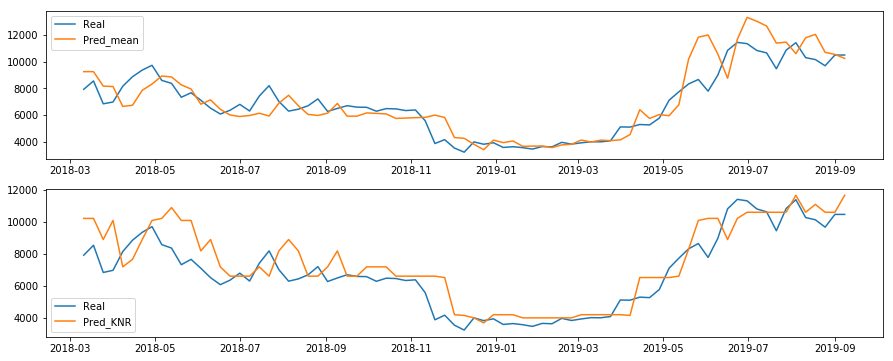

In [33]:
f, ax = plt.subplots(2, 1, figsize = (15,6))
ax[0].plot(datt['Real'])
ax[0].plot(datt['Pred_mean'])
ax[0].legend()

ax[1].plot(datt['Real'])
ax[1].plot(datt['Pred_KNR'])
ax[1].legend()

### Third try, same slices as second, but with less features

In [34]:
drop_col = ['Price_log_nw', 'Volume', 'Market Cap','Price','Price_log','Trend_evo','Price_evo','Price_evo+','Trend_evo+']
X_train = df[0:182].drop(drop_col, axis=1)
y_train = df[0:182]['Price_log_nw']
X_valid = df[182:].drop(drop_col, axis=1)
y_valid = df[182:]['Price_log_nw']

lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
y_pred1 = lr_fit.predict(X_valid)

ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds))
ridge_fit = ridge.fit(X_train, y_train)
y_pred2 = ridge_fit.predict(X_valid)

lasso = make_pipeline(StandardScaler(), LassoCV(max_iter=1e7, alphas=alphas_lasso, random_state=42, cv=kfolds))
lasso_fit = lasso.fit(X_train, y_train)
y_pred3 = lasso_fit.predict(X_valid)

datt = pd.DataFrame({'Real':np.exp(y_valid), 'Pred_LR':np.exp(y_pred1), 'Pred_Ridge':np.exp(y_pred2),'Pred_Lasso':np.exp(y_pred3)})
datt = datt.sort_index()
datt['Pred_mean'] = (datt['Pred_LR'] + datt['Pred_Ridge'] + datt['Pred_Lasso']) / 3

datt['Pred_LR'] = get_timepred(datt['Pred_LR'])
datt['Pred_Ridge'] = get_timepred(datt['Pred_Ridge'])
datt['Pred_Lasso'] = get_timepred(datt['Pred_Lasso'])
datt['Pred_mean'] = get_timepred(datt['Pred_mean'])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to floa

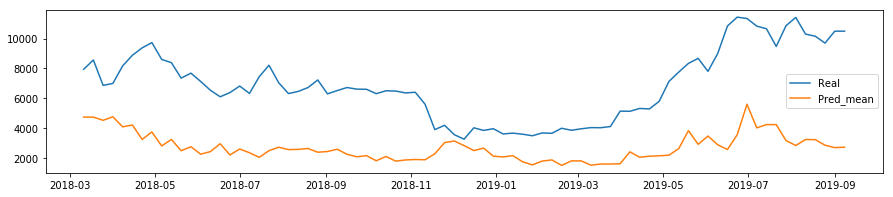

In [35]:
f, ax = plt.subplots(1, 1, figsize = (15,3))
plt.plot(datt['Real'])
plt.plot(datt['Pred_mean'])
plt.legend()

## Conclusions

### From this notebook
- Possible to get data from Google Trends (week data)
- Ok for web scraping BTC price on CoinMarketCap
- Predictions for the next week is a realistic goal
- Results given by the actual predictions are late (~2 weeks)
- The last try gives an interesting trend (even if predictions are wrong)
<br />. . .
### Some more options for the future:
- Try something with Twitter scraping and sentiment analysis (closer to real time than Google Trends)
- Using Time Series algorithms (i read about ARIMA, or NNAR. With evaluation with RMSE, MAPE, MASE)
- Check traditional indicators calculus (Fibonacci, RSI, etc..)
<br />. . .
### And some more questions:
- Can we really predict BTC price ? Knowing "whales" control big volume of crypto, and that this economy is a very manipulated.
- Can we explain the boom of the crypto in decembre 2017 ? Does it exist rationnal explanations to that ?
- ... 
